[View in Colaboratory](https://colab.research.google.com/github/leemordechai/DataScienceProject-2018Fall/blob/master/ND_DS_Chemistry_Cleaning.ipynb)

In [3]:
from google.colab import files
import io
import ast 
uploaded = files.upload() 


Saving third_dataset_09_12_2018.csv to third_dataset_09_12_2018 (1).csv


In [4]:
!pip install pymatgen
import pandas as pd 
raw_df = pd.read_csv(io.StringIO(uploaded['third_dataset_09_12_2018.csv'].decode('utf-8'))) 
# if reading from a local csv file, uncomment the following line instead: 
#df = pd.read_csv('Dataset-film-data.csv') 
import warnings 
warnings.filterwarnings("ignore")
print(raw_df.shape) 
raw_df.head()

(83989, 2)


,material_id,pretty_formula
0,mp-1,Cs
1,mp-10,As
2,mp-100,Hf
3,mp-1000,BaTe
4,mp-10000,Hf2S


In [5]:
from pymatgen import Composition, Element

def invalids(x):
  if type(x) == float: return True

# Some necessary cleaning since some materials have no formula
df1 = raw_df[raw_df['pretty_formula'].apply(invalids) != True]
# print(len(raw_df), len(df1)) # 83989, 83987

# add another column to the df, Composition
df1['Composition'] = df1['pretty_formula'].apply(lambda x: Composition(x))
print(df1['Composition'].apply(len).value_counts()) # about 8000 materials have 1 or 5-8 elements
# derive number of elements of each material from its composition
df1['Num_Elements'] = df1['Composition'].apply(len)

df2 = df1[(df1['Num_Elements'] > 1) & (df1['Num_Elements'] < 5)]
len(df2)
  


3    40389
4    21594
2    13858
5     6614
6      870
1      589
7       68
8        5
Name: Composition, dtype: int64


75841

In [6]:
import collections

counter = collections.Counter()
df2['Composition'].apply(lambda x: counter.update(list(x)))

counter.most_common(5) # this is different from Yifan's results since looking at df2 (not df1)

[(Element O, 36517),
 (Element Li, 11720),
 (Element Mg, 9484),
 (Element P, 7364),
 (Element F, 6073)]

In [0]:
freq_elements = []
df_element_frequencies = pd.DataFrame(columns=['Element', 'Freq'])
for elem, num in counter.most_common(): # parentheses () to see all
  freq_elements.append(elem)
  df_element_frequencies = df_element_frequencies.append({'Element': str(elem), 'Freq': num}, ignore_index=True)

least_frequent_elements = freq_elements[:80:-1] # is now a list of the least frequent elements (out of top 80)

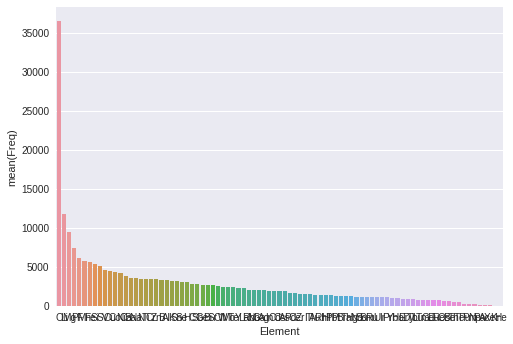

In [8]:
# visualize the elements
import seaborn as sns
df_element_frequencies.head()
sns.barplot(x='Element', y='Freq', data = df_element_frequencies)


In [9]:
df2.head()

,material_id,pretty_formula,Composition,Num_Elements
3,mp-1000,BaTe,"(Ba, Te)",2
4,mp-10000,Hf2S,"(Hf, S)",2
5,mp-10003,Nb4CoSi,"(Nb, Co, Si)",3
6,mp-10004,Mo3P,"(Mo, P)",2
7,mp-1000440,CrN,"(Cr, N)",2


In [10]:
df2['pretty_formula'].head().apply(lambda x: Composition(x))


3        (Ba, Te)
4         (Hf, S)
5    (Nb, Co, Si)
6         (Mo, P)
7         (Cr, N)
Name: pretty_formula, dtype: object

<h3>Note the issue in the cell below, which influences the overall results:</h3>
In particular, this determines which elements we're interested in. Yifan selected only the top 80 single elements, but it seems to me that the original paper's authors were also interested in compounds (SI, p. 2)

In [11]:
#note the major difference between:
first_method = df2[df2['pretty_formula'] == 'NiO2']
second_method = df2[df2['pretty_formula'].str.contains('NiO2')]
print(len(first_method), len(second_method))
# the second method seems similar to what the authors of the original paper used (NiO2 ~= 100)

18 222


In [12]:
for i in range(len(least_frequent_elements)):
  least_frequent_elements[i] = str(least_frequent_elements[i])

least_frequent_elements # this is a list of Strings, not Elements
regex_string = ''
for i in least_frequent_elements:
  regex_string = regex_string + i + '|'

regex_string = regex_string[:-1] # getting rid of last char
regex_string

'He|Kr|Xe|Ac|Pa|Np'

In [13]:
# removing everything which has one of the rare elements
df3 = df2[df2['Composition'].apply(lambda x: str(x)).str.contains(regex_string) == False]

# these are some of the entries we've removed:
df2[df2['Composition'].apply(lambda x: str(x)).str.contains(regex_string) == True].head()


,material_id,pretty_formula,Composition,Num_Elements
238,mp-1005719,Sm3Np,"(Sm, Np)",2
239,mp-1005727,TmNp3,"(Tm, Np)",2
258,mp-1006056,PaNi2Ge,"(Pa, Ni, Ge)",3
268,mp-1006127,Pa3Mo,"(Pa, Mo)",2
278,mp-1006245,ErNp3,"(Er, Np)",2


In [14]:
df3.head()

,material_id,pretty_formula,Composition,Num_Elements
3,mp-1000,BaTe,"(Ba, Te)",2
4,mp-10000,Hf2S,"(Hf, S)",2
5,mp-10003,Nb4CoSi,"(Nb, Co, Si)",3
6,mp-10004,Mo3P,"(Mo, P)",2
7,mp-1000440,CrN,"(Cr, N)",2


In [0]:
from pymatgen import MPRester                                                     
import urllib.request                                                             
import json
                                                                                  
MAPI_KEY = "zQIrujyVEwEhTBRW"  # API key
                                                                                  
with MPRester(MAPI_KEY) as m: # object for connecting to MP Rest interface 
  criteria={'material_id': {'$in': list(df3['material_id'])}} # can add '.head(7)' for testing
  properties=['energy', 'pretty_formula','total_electrons','density']
  data = m.query(criteria, properties)                                      

In [16]:
downloaded_details = pd.DataFrame.from_dict(data)
downloaded_details.head()

,density,energy,pretty_formula,total_electrons
0,4.937886,-8.647345,BaTe,None
1,11.035292,-54.265245,Hf2S,None
2,7.830812,-110.093972,Nb4CoSi,None
3,8.991405,-157.398310,Mo3P,None
4,6.101436,-18.643520,CrN,None


In [17]:
df4 = df3.copy().reset_index()
df4['Density'] = downloaded_details['density']
df4['Energy'] = downloaded_details['energy']
df4['Total Electrons'] = downloaded_details['total_electrons']

df4 = df4.drop('index', axis=1)
df4.head()


,material_id,pretty_formula,Composition,Num_Elements,Density,Energy,Total Electrons
0,mp-1000,BaTe,"(Ba, Te)",2,4.937886,-8.647345,None
1,mp-10000,Hf2S,"(Hf, S)",2,11.035292,-54.265245,None
2,mp-10003,Nb4CoSi,"(Nb, Co, Si)",3,7.830812,-110.093972,None
3,mp-10004,Mo3P,"(Mo, P)",2,8.991405,-157.398310,None
4,mp-1000440,CrN,"(Cr, N)",2,6.101436,-18.643520,None


In [18]:
df4.corr()

,Num_Elements,Density,Energy
Num_Elements,1.000000,-0.280027,-0.344016
Density,-0.280027,1.000000,0.206637
Energy,-0.344016,0.206637,1.000000


In [0]:
filename = 'cleaned_data_09_18_2018.csv'
df4.to_csv(filename)
files.download(filename) 

<h1>Matrix Creation</h1>
<h3>Begins here:</h3>

In [20]:
df4.head()

,material_id,pretty_formula,Composition,Num_Elements,Density,Energy,Total Electrons
0,mp-1000,BaTe,"(Ba, Te)",2,4.937886,-8.647345,None
1,mp-10000,Hf2S,"(Hf, S)",2,11.035292,-54.265245,None
2,mp-10003,Nb4CoSi,"(Nb, Co, Si)",3,7.830812,-110.093972,None
3,mp-10004,Mo3P,"(Mo, P)",2,8.991405,-157.398310,None
4,mp-1000440,CrN,"(Cr, N)",2,6.101436,-18.643520,None


In [21]:
chars = set()
df4['pretty_formula'].apply(lambda x: chars.update(list(x)))
print(sorted(chars)) # looks normal, only parentheses, numbers and letters

['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'y']


In [26]:
import itertools

def extract_element(str):
  num = [s for s in list(str) if s.isdigit()]
  elem = ''.join([s for s in list(str) if s.isdigit() == False])
  num = int(''.join(num))
  if num >= 1: return [elem, num]
  else: return [elem, 1]

print(extract_element('Nb4')) # test

def environments(compo, feedback=False):
  complete_elements = []
  all_environments = []
  removed_elements = []
  
  for ele in compo:
    num_of_element = int(compo[ele])
    if num_of_element == 0: num_of_element = 1
    full_element = str(ele) + str(num_of_element)
    complete_elements.append(full_element)
  for i in itertools.permutations(complete_elements):
    j = [k for k in i]
    el, nu = extract_element(j[0])
    j[0] = str(nu)
    if feedback == True: print(''.join(j))
    all_environments.append(''.join(j))
    removed_elements.append(el)
  
  return [removed_elements, all_environments]

print(df4['Composition'][1])
environments(df4['Composition'][1], feedback=False)

['Nb', 4]
Hf2 S1


[['Hf', 'S'], ['2S1', '1Hf2']]

In [27]:
test_results = df4['Composition'].head(20).apply(lambda x: environments(x)[1]) #, feedback=True))
environment_counter = collections.Counter()
test_results.apply(lambda x: environment_counter.update(list(x)))
environment_counter.most_common(10)

[('1Te1', 2),
 ('1Yb1S2', 2),
 ('1S2Yb1', 2),
 ('1Ba1', 1),
 ('2S1', 1),
 ('1Hf2', 1),
 ('4Co1Si1', 1),
 ('4Si1Co1', 1),
 ('1Nb4Si1', 1),
 ('1Si1Nb4', 1)]

In [28]:
df4.head(20)

,material_id,pretty_formula,Composition,Num_Elements,Density,Energy,Total Electrons
0,mp-1000,BaTe,"(Ba, Te)",2,4.937886,-8.647345,None
1,mp-10000,Hf2S,"(Hf, S)",2,11.035292,-54.265245,None
2,mp-10003,Nb4CoSi,"(Nb, Co, Si)",3,7.830812,-110.093972,None
3,mp-10004,Mo3P,"(Mo, P)",2,8.991405,-157.398310,None
4,mp-1000440,CrN,"(Cr, N)",2,6.101436,-18.643520,None
5,mp-1000487,CeAlO3,"(Ce, Al, O)",3,6.580909,-40.418431,None
6,mp-1000588,U2IrC2,"(U, Ir, C)",3,15.206073,-51.542110,None
7,mp-10006,TlAgTe2,"(Tl, Ag, Te)",3,7.781762,-11.648500,None
8,mp-1000625,K(CoSe)2,"(K, Co, Se)",3,5.172313,-24.697659,None
9,mp-1000712,RbYbS2,"(Rb, Yb, S)",3,4.595989,-15.922842,None


In [29]:
results = df4['Composition'].apply(lambda x: environments(x)[1])
environment_counter = collections.Counter()
results.apply(lambda x: environment_counter.update(list(x)))
print(len(environment_counter))
environment_counter.most_common(20)


326964


[('1O2', 749),
 ('1Li1P1O4', 382),
 ('1Li1O4P1', 382),
 ('1P1Li1O4', 382),
 ('1P1O4Li1', 382),
 ('1O4Li1P1', 382),
 ('1O4P1Li1', 382),
 ('2Si1', 358),
 ('1Mg1', 355),
 ('2Mg1', 327),
 ('1Se2', 275),
 ('1S1', 273),
 ('1N1', 272),
 ('1Mg2', 255),
 ('2Mg1O4', 239),
 ('2O4Mg1', 239),
 ('2Ce1', 235),
 ('2Ca1O4', 234),
 ('2O4Ca1', 234),
 ('1O1F1', 229)]

In [30]:
df_env_frequencies = pd.DataFrame(columns=['Environment', 'Freq'])
freq_environments = []
num_environments = []
for env, num in environment_counter.most_common(): #10): # parentheses () to see all
  freq_environments.append(env)
  num_environments.append(num)

df_env_frequencies['Environment'] = freq_environments
df_env_frequencies['Freq'] = num_environments

print(len(df_env_frequencies))
df_env_frequencies.head()



326964


,Environment,Freq
0,1O2,749
1,1Li1P1O4,382
2,1Li1O4P1,382
3,1P1Li1O4,382
4,1P1O4Li1,382


In [38]:
element_list = [str(i) for i in freq_elements][:81] # based on the top 80 elements
df_sparse = pd.DataFrame(0, index=element_list, columns=df_env_frequencies['Environment'])

df_sparse.head()

Environment,1O2,1Li1P1O4,1Li1O4P1,1P1Li1O4,1P1O4Li1,1O4Li1P1,1O4P1Li1,2Si1,1Mg1,2Mg1,...,8Mn2Ca1P2,8Mn2P2Ca1,8P2Ca1Mn2,8P2Mn2Ca1,6Ca1La1Cr2,6Ca1Cr2La1,6La1Ca1Cr2,6La1Cr2Ca1,6Cr2Ca1La1,6Cr2La1Ca1
O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Li,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
for k in range(len(df4)):
  elems, envs = environments(df4['Composition'].iloc[k])
  try:
    for i in range(len(elems)):
      df_sparse.loc[elems[i]][envs[i]] += 1
  except:
    print(k)
  if i % 50000 == 0: print(i)
#df_sparse.sum(axis=1) #O:144823; Li:53949; Mg: 30516; P: 33135; F 18532

O     144823
Li     53949
Mg     30516
P      33135
F      18532
Mn     21072
Fe     20841
Si     17339
S      16091
V      17713
Cu     15913
Co     15337
Ni     13582
Ca     12399
Ba     13070
Na     12627
N      10554
Ti     11173
Cr     12536
Zn     10296
B      12589
Al      9464
K      11876
Sn      8886
Se      9265
H      12145
C       9860
Sb      8050
Ge      6970
Bi      8444
       ...  
Rh      2768
Hf      3768
Pb      3530
Pt      2443
Br      3417
Ta      3550
Hg      2854
Nd      3057
Sc      2585
Sm      2746
Ru      2678
U       2824
Ir      2484
Pr      2752
Yb      2095
Ho      2223
Er      2053
Dy      1991
Tb      1900
Lu      1690
Tm      1611
Gd      1882
Eu      1785
Re      1833
Os      1455
Be      1577
Th       998
Tc       823
Pu       374
Pm       404
Length: 81, dtype: int64

In [40]:
df_sparse.head()

Environment,1O2,1Li1P1O4,1Li1O4P1,1P1Li1O4,1P1O4Li1,1O4Li1P1,1O4P1Li1,2Si1,1Mg1,2Mg1,...,8Mn2Ca1P2,8Mn2P2Ca1,8P2Ca1Mn2,8P2Mn2Ca1,6Ca1La1Cr2,6Ca1Cr2La1,6La1Ca1Cr2,6La1Cr2Ca1,6Cr2Ca1La1,6Cr2La1Ca1
O,0,0,0,0,0,0,0,282,7,2,...,1,1,1,1,1,1,1,1,1,1
Li,4,0,0,0,0,0,0,1,17,12,...,0,0,0,0,0,0,0,0,0,0
Mg,2,1,1,1,1,1,1,35,0,0,...,0,0,0,0,0,0,0,0,0,0
P,1,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0


In [0]:
matrix_filename = 'matrix-large-09-18-2018.csv' 
df_sparse.to_csv(matrix_filename)
files.download(matrix_filename) # 50 MB